In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyod.models.mad import MAD
from scipy.stats import normaltest
import lightgbm as lgb
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, confusion_matrix
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 150)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
sns.set()
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)
from imports import *
import gc
import pickle

# Feature Generation

In [4]:
def application_data(path):
    df=pd.read_csv(path)
    df['DAYS_EMPLOYED']=df['DAYS_EMPLOYED'].replace(365243, np.nan)
    df=generate_domain_features(df)
    return convert_types(df)


def bureau_and_bb(bur_path, bb_path, enc_mode='test', bur_ohe=None, bb_ohe=None):
    bur=convert_types(pd.read_csv(bur_path))
    bb=convert_types(pd.read_csv(bb_path))
    print(f'Bureau shape before: {bur.shape}')
    print(f'Bureau balance shape before: {bb.shape}')
    if not bb_ohe:
        bb_ohe=OneHotEncoder(sparse=False, handle_unknown='ignore')
        enc_mode='train'
    bb_numeric_agg_df=numeric_agg(bb, 'SK_ID_BUREAU', 'bureau_balance')
    bb_categ_agg_df=categ_agg(bb, 'SK_ID_BUREAU', 'bureau_balance', bb_ohe, enc_mode)
    bb_full=bb_numeric_agg_df.merge(bb_categ_agg_df, on='SK_ID_BUREAU', how='outer')
    bb_by_credit=bur[['SK_ID_BUREAU', 'SK_ID_CURR']].merge(bb_full, on='SK_ID_BUREAU', how='left') 
    bb=numeric_agg(bb_by_credit, 'SK_ID_CURR', 'loan') 
    if not bur_ohe:
        bur_ohe=OneHotEncoder(sparse=False, handle_unknown='ignore')
        enc_mode='train'
    bur=agg_combine(bur, ['SK_ID_CURR'], ['bureau'], bur_ohe, enc_mode)
    del bb_numeric_agg_df, bb_categ_agg_df, bb_full, bb_by_credit; gc.collect()
    return bur, bb, bur_ohe, bb_ohe


def previous(prev_path, enc_mode='test', prev_ohe=None):
    prev=convert_types(pd.read_csv(prev_path))
    for c in ['DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION']:
        prev[c]=prev[c].replace(365243, np.nan)
    if not prev_ohe:
        prev_ohe=OneHotEncoder(sparse=False, handle_unknown='ignore')
        enc_mode='train'
    prev=agg_combine(prev, ['SK_ID_CURR'], ['previous'], prev_ohe, enc_mode)
    return prev, prev_ohe


def pos_cash(cash_path, enc_mode='test', cash_ohe=None):
    cash=convert_types(pd.read_csv(cash_path))
    if not cash_ohe:
        cash_ohe=OneHotEncoder(sparse=False, handle_unknown='ignore')
        enc_mode='train'
    cash=agg_combine(cash, ['SK_ID_CURR', 'SK_ID_PREV'], ['loan', 'cash'], cash_ohe, enc_mode, agg_level=2)
    return cash, cash_ohe


def installments(inst_path):
    inst=convert_types(pd.read_csv(inst_path))
    inst_agg_by_prev=numeric_agg(inst, 'SK_ID_PREV', 'inst')
    inst_agg_by_prev=inst[['SK_ID_PREV', 'SK_ID_CURR']].merge(inst_agg_by_prev, on='SK_ID_PREV', how='right')
    inst=numeric_agg(inst_agg_by_prev, 'SK_ID_CURR', 'loan')
    del inst_agg_by_prev; gc.collect()
    return inst


def card_balance(card_path, enc_mode='test', card_ohe=None):
    card_balance=convert_types(pd.read_csv(card_path))
    if not card_ohe:
        card_ohe=OneHotEncoder(sparse=False, handle_unknown='ignore')
        enc_mode='train'
    card_balance=agg_combine(card_balance, ['SK_ID_CURR', 'SK_ID_PREV'], ['loan', 'card'], card_ohe, enc_mode, agg_level=2)
    return card_balance, card_ohe


path_dict={
    'application_train': '../data/application_train.csv',
    'application_test': '../data/application_test.csv',
    'bur': '../data/bureau.csv',
    'bb': '../data/bureau_balance.csv',
    'previous': '../data/previous_application.csv',
    'cash': '../data/POS_CASH_balance.csv',
    'installments': '../data/installments_payments.csv',
    'card_balance': '../data/credit_card_balance.csv',
    'ohe_dict': '../models/pipeline/ohe_dict.pkl',
}


def full_df(path_dict, ohe_dict_bool, mode='train'):
    if mode=='train' and not ohe_dict_bool:
        ohe_dict={}
        app=application_data(path_dict['application_train'])
        bur, bb, bur_ohe, bb_ohe=bureau_and_bb(path_dict['bur'], path_dict['bb'])
        app=app.merge(bur, on='SK_ID_CURR', how='left')
        ohe_dict['Bureau_OHE']=bur_ohe
        ohe_dict['BB_OHE']= bb_ohe
        del bur, bur_ohe; gc.collect()
        app=app.merge(bb, on='SK_ID_CURR', how='left')
        del bb, bb_ohe; gc.collect()
        
        prev, prev_ohe=previous(path_dict['previous'])
        app=app.merge(prev, on='SK_ID_CURR', how='left')
        ohe_dict['Prev_OHE']= prev_ohe
        del prev, prev_ohe; gc.collect()
        
        cash, cash_ohe=pos_cash(path_dict['cash'])
        app=app.merge(cash, on='SK_ID_CURR', how='left')
        ohe_dict['Cash_OHE']= cash_ohe
        del cash, cash_ohe; gc.collect()
        
        inst=installments(path_dict['installments'])
        app=app.merge(inst, on='SK_ID_CURR', how='left')
        del inst; gc.collect()
        
        card_b, card_b_ohe=card_balance(path_dict['card_balance'])
        app=app.merge(card_b, on='SK_ID_CURR', how='left')
        ohe_dict['Card_OHE']=card_b_ohe
        del card_b, card_b_ohe; gc.collect()
       
        with open(path_dict['ohe_dict'], 'wb') as f:
            pickle.dump(ohe_dict, f)
        
    elif mode=='test' and ohe_dict_bool:
        with open(path_dict['ohe_dict'], 'rb') as f:
            ohe_dict=pickle.load(f)
        app=application_data(path_dict['application_test'])
        bur, bb, _, _=bureau_and_bb(path_dict['bur'], 
                                    path_dict['bb'], 
                                    bur_ohe=ohe_dict['Bureau_OHE'], 
                                    bb_ohe=ohe_dict['BB_OHE'])
        app=app.merge(bur, on='SK_ID_CURR', how='left')
        del bur; gc.collect()
        app=app.merge(bb, on='SK_ID_CURR', how='left')
        del bb; gc.collect()
        
        prev, _=previous(path_dict['previous'], prev_ohe=ohe_dict['Prev_OHE'])
        app=app.merge(prev, on='SK_ID_CURR', how='left')
        del prev; gc.collect()
        
        cash, _=pos_cash(path_dict['cash'], cash_ohe=ohe_dict['Cash_OHE'])
        app=app.merge(cash, on='SK_ID_CURR', how='left')
        del cash; gc.collect()
        
        inst=installments(path_dict['installments'])
        app=app.merge(inst, on='SK_ID_CURR', how='left')
        del inst; gc.collect()
        
        card_b, _=card_balance(path_dict['card_balance'], card_ohe=ohe_dict['Card_OHE'])
        app=app.merge(card_b, on='SK_ID_CURR', how='left')
        del card_b; gc.collect()
    else:
        raise Exception("Specify mode (train of test) and OHE dict bool")
    return convert_types(app)

In [5]:
train=full_df(path_dict, False, mode='train')
train.shape

Before adding features: (307511, 122)
After adding features: (307511, 166)
Bureau shape before: (1716428, 17)
Bureau balance shape before: (27299925, 3)
Dataset:bureau_balance
	Before: 2 numeric cols
	After: 5
Dataset:bureau_balance
	Before: 1 categorical cols
	After: 16
Dataset:loan
	Before: 22 numeric cols
	After: 85
Dataset:bureau
	Before: 3 categorical cols
	After: 46
Dataset:bureau
	Before: 13 numeric cols
	After: 56
Dataset:previous
	Before: 16 categorical cols
	After: 286
Dataset:previous
	Before: 19 numeric cols
	After: 85
Dataset:cash
	Before: 1 categorical cols
	After: 18
Dataset:cash
	Before: 6 numeric cols
	After: 23
Dataset:loan
	Before: 42 numeric cols
	After: 162
Dataset:inst
	Before: 7 numeric cols
	After: 26
Dataset:loan
	Before: 27 numeric cols
	After: 106
Dataset:card
	Before: 1 categorical cols
	After: 14
Dataset:card
	Before: 21 numeric cols
	After: 83
Dataset:loan
	Before: 98 numeric cols
	After: 376


(307511, 1368)

In [6]:
test=full_df(path_dict, True, mode='test')
test.shape

Before adding features: (48744, 121)
After adding features: (48744, 165)
Bureau shape before: (1716428, 17)
Bureau balance shape before: (27299925, 3)
Dataset:bureau_balance
	Before: 2 numeric cols
	After: 5
Dataset:bureau_balance
	Before: 1 categorical cols
	After: 16
Dataset:loan
	Before: 22 numeric cols
	After: 85
Dataset:bureau
	Before: 3 categorical cols
	After: 46
Dataset:bureau
	Before: 13 numeric cols
	After: 56
Dataset:previous
	Before: 16 categorical cols
	After: 286
Dataset:previous
	Before: 19 numeric cols
	After: 85
Dataset:cash
	Before: 1 categorical cols
	After: 18
Dataset:cash
	Before: 6 numeric cols
	After: 23
Dataset:loan
	Before: 42 numeric cols
	After: 162
Dataset:inst
	Before: 7 numeric cols
	After: 26
Dataset:loan
	Before: 27 numeric cols
	After: 106
Dataset:card
	Before: 1 categorical cols
	After: 14
Dataset:card
	Before: 21 numeric cols
	After: 83
Dataset:loan
	Before: 98 numeric cols
	After: 376


(48744, 1367)

In [7]:
set(train.columns)-set(test.columns)

{'TARGET'}

In [8]:
# def quick_cv(df):
#     X, y=df.drop(['SK_ID_CURR', 'TARGET'], axis=1), df['TARGET']
#     cat_cols, num_cols=X.select_dtypes(include=['category', 'object']).columns, X.select_dtypes('number').columns

#     ohe=OneHotEncoder(sparse=False, handle_unknown='ignore')
#     col_tr=ColumnTransformer([
#         ('cat', ohe, cat_cols),
#         ('num', 'passthrough', num_cols)
#     ])

#     res, importances=custom_lgbm_cv(X, y, col_tr)
#     return res, importances

# Feature Selection

## Correlation

In [9]:
def correlation_filter(df, thresh, corr_path, mode='train'):
    if mode=='train':
        corr_mat=df.drop(['TARGET'], axis=1).corr().abs()
        upper=corr_mat.where(np.triu(np.ones(corr_mat.shape), k=1).astype(np.bool))
        upper.to_csv(corr_path, index=False)
    elif mode=='test':
        upper=pd.read_csv(corr_path)
    to_drop=[column for column in upper.columns if any(upper[column]>thresh)]
    print(f'Correlation: {len(to_drop)} will be removed')
    return df.drop(to_drop, axis=1)

In [10]:
train=correlation_filter(train, 0.9, '../data/corr_matrix.csv', 
                         mode='test',
#                         mode='train',
                        )
train.shape

Correlation: 619 will be removed


(307511, 749)

In [11]:
test=correlation_filter(test, 0.9, '../data/corr_matrix.csv', mode='test')
test.shape

Correlation: 619 will be removed


(48744, 748)

In [12]:
set(train.columns)-set(test.columns)

{'TARGET'}

## Missing

In [13]:
def missing_filter(df, thresh, col_path, mode='train'):
    if mode=='train':
        mt=miss_table(df)
        to_drop=mt.loc[mt['Percent']>thresh].index
        with open(col_path, 'wb') as f:
            pickle.dump(to_drop, f)
    elif mode=='test':
        with open(col_path, 'rb') as f:
            to_drop=pickle.load(f)
    else:
        raise Exception("Specify mode (train of test) and path")
    print(f'{len(to_drop)} features with {thresh}% of NaNs will be removed')
    return df.drop(to_drop, axis=1)

In [14]:
train=missing_filter(train, 80, '../models/pipeline/missing_columns_drop.pkl', 'train',)

There are 689/749 columns with missing values
Distribution by dtypes:
float32     683
category      1
category      1
category      1
category      1
category      1
category      1
Name: Dtype, dtype: int64
16 features with 80% of NaNs will be removed


In [15]:
test=missing_filter(test, 80, '../models/pipeline/missing_columns_drop.pkl', 'test')

16 features with 80% of NaNs will be removed


In [16]:
set(train.columns)-set(test.columns)

{'TARGET'}

## Zero Variance

In [17]:
def zero_var_filter(df, col_path, mode='train'):
    if mode=='train':
        scaler=MinMaxScaler()
        numeric_data=df.drop('SK_ID_CURR', axis=1).select_dtypes('number').reset_index(drop=True)
        numeric_data.replace([np.inf, -np.inf], np.nan, inplace=True)
        for i in numeric_data.columns:
            numeric_data[i].fillna(value=numeric_data[i].mean(), inplace=True) #replace NaN with mean of dimension
            numeric_data[i]=scaler.fit_transform(numeric_data[i].values.reshape(-1,1)) 
        vars_df=numeric_data.var()
        to_drop=vars_df[vars_df==0].index
        with open(col_path, 'wb') as f:
            pickle.dump(to_drop, f)
    
    elif mode=='test':
        with open(col_path, 'rb') as f:
            to_drop=pickle.load(f)
    else:
        raise Exception("Specify mode (train of test) and path")
    print(f'{len(to_drop)} features with zero variance will be removed')
    return df.drop(to_drop, axis=1)

In [18]:
train=zero_var_filter(train, '../models/pipeline/zero_var_columns_drop.pkl', 'test')

5 features with zero variance will be removed


In [19]:
test=zero_var_filter(test, '../models/pipeline/zero_var_columns_drop.pkl', 'test')

5 features with zero variance will be removed


In [20]:
set(train.columns)-set(test.columns)

{'TARGET'}

## Zero Feature Importance

In [21]:
def feat_imp_cv(df, feat_imp_path, k=5, params=None, mode='train'):
    if mode=='train':
        X, y=df.drop('TARGET', axis=1), df['TARGET']
        feat_importances_gain, feat_importances_split=[], []
        kfold=StratifiedKFold(k)
        for f, (tr, te) in enumerate(kfold.split(X, y=y)):
            X_train, y_train=X.iloc[tr, :], y.iloc[tr]
            X_test, y_test=X.iloc[te, :], y.iloc[te]
            weight=np.count_nonzero(y_train==0)/np.count_nonzero(y_train==1)
            params['scale_pos_weight']=weight
            dtrain=lgb.Dataset(X_train, label=y_train, params={'verbose': -1})
            dval=lgb.Dataset(X_test, label=y_test, params={'verbose': -1})
            model=lgb.train(
                            params=params,
                            train_set=dtrain,
                            valid_sets=[dtrain, dval],
                            valid_names=['train', 'test'],
                            categorical_feature=list(X.select_dtypes(['category']).columns),
                            callbacks=[lgb.early_stopping(100, verbose=-1)],
                            verbose_eval=False
                            )
            feat_importances_gain.append(model.feature_importance(importance_type='gain'))
            feat_importances_split.append(model.feature_importance(importance_type='split'))
            
        feat_importances_gain=np.array(feat_importances_gain).mean(axis=0)
        feat_importances_split=np.array(feat_importances_split).mean(axis=0)
        feat_importances_df=pd.DataFrame({'feature': list(X.columns),
                                        'importance (gain)': feat_importances_gain,
                                        'importance (split)': feat_importances_split,})
        with open(feat_imp_path, 'wb') as f:
            pickle.dump(feat_importances_df, f)
    
    elif mode=='test':
        with open(feat_imp_path, 'rb') as f:
            feat_importances_df=pickle.load(f)
    
    else:
        raise Exception("Specify mode (train of test) and path")
    return feat_importances_df

In [22]:
def drop_zero_imp(df, feat_imp_path, k=5, params=None, mode='train', drop_by='importance (gain)'):
    feature_imp_df=feat_imp_cv(df, feat_imp_path, k, params, mode=mode)
    to_drop=feature_imp_df[feature_imp_df[drop_by]==0]['feature'].values
    print(f'Num of features with zero importance: {len(to_drop)}')
    return df.drop(to_drop, axis=1)

In [23]:
import re
train=train.rename(columns=lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
test=test.rename(columns=lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

params={'num_boost_round': 10000,
        'objective': 'binary',
        'metric': 'auc',
        'learning_rate': 0.05,
        'reg_alpha': 0.1,
        'reg_lambda': 0.1,
        'subsample': 0.8,
        'n_jobs': -1,
        'random_state': 5,
       'verbose': -1}

train=drop_zero_imp(train, '../models/pipeline/zero_imp.pkl', 5, params, 'train')

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[383]	train's auc: 0.87577	test's auc: 0.783501
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[413]	train's auc: 0.879807	test's auc: 0.787868
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[316]	train's auc: 0.865129	test's auc: 0.780138
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[250]	train's auc: 0.851291	test's auc: 0.785895
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[427]	train's auc: 0.881463	test's auc: 0.782358
Num of features with zero importance: 172


In [24]:
test=drop_zero_imp(test, '../models/pipeline/zero_imp.pkl', 5, params, 'test')

Num of features with zero importance: 172


In [25]:
set(train.columns)-set(test.columns)

{'TARGET'}

## Modelling

In [32]:
def train_model(X, y, params, model_path):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=52, stratify=y)
    dtrain=lgb.Dataset(X_train, label=y_train, params={'verbose': -1})
    dval=lgb.Dataset(X_val, label=y_val, params={'verbose': -1})
    weight=np.count_nonzero(y==0)/np.count_nonzero(y==1)
    params['scale_pos_weight']=weight
    model=lgb.train(
                    params=params,
                    train_set=dtrain,
                    valid_sets=[dtrain, dval],
                    valid_names=['train', 'test'],
                    categorical_feature=list(X.select_dtypes(['category']).columns),
                    callbacks=[lgb.early_stopping(100, verbose=-1)],
                    verbose_eval=False
                    )
    model.save_model(model_path)
    return f'Model is saved in {model_path}'

In [28]:
def make_prediction(X, model_path):
    model=lgb.Booster(model_file=model_path)
    return model.predict(X)

In [33]:
params={'num_boost_round': 10000,
        'objective': 'binary',
        'metric': 'auc',
        'learning_rate': 0.05,
        'reg_alpha': 0.1,
        'reg_lambda': 0.1,
        'subsample': 0.8,
        'n_jobs': -1,
        'random_state': 5,
       'verbose': -1}

X, y=train.drop('TARGET', axis=1), train['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=52, stratify=y)

train_model(X_train, y_train, params, '../models/model.txt')
pred=make_prediction(X_test, '../models/model.txt')

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[251]	train's auc: 0.864528	test's auc: 0.781801


In [37]:
def conf_matrix(y_true, y_pred):    
    # Creating a confusion matrix
    con_mat = confusion_matrix(y_true, y_pred)
    group_counts = ['{0:0.0f}'.format(value) for value in
                con_mat.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                         con_mat.flatten()/np.sum(con_mat)]
    labels = [f'{v1}\n{v2}' for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    #Ploting the confusion matrix
    plt.figure(figsize=(3, 3))
    sns.set(font_scale=1.5) 
    plt.title("Confusion Matrix")
    s=sns.heatmap(con_mat, annot=labels, annot_kws={"size": 16}, fmt='', cmap='Blues', cbar=False)
    s.set(ylabel='True', xlabel='Pred')
    plt.show()

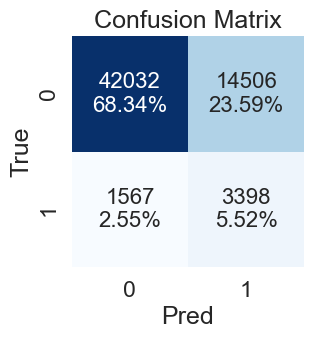

In [41]:
conf_matrix(y_test, np.where(pred>=0.5, 1, 0))

array([0, 0, 0, ..., 0, 1, 1])